# GECCO2018 Water Quality — Notebook 02: Time-Aware Visualizations

Este notebook foca em visualizações orientadas a série temporal do dataset GECCO2018.

Objetivos:
- Carregar o dataset e aplicar limpezas básicas (parse de `Time`, coerção de tipos, remoção de nulos).
- Visualizar séries temporais das variáveis sensoriais com indicação de `EVENT`.
- Explorar distribuições e correlações entre sensores.
- Salvar figuras principais em `reports/figures/`.

In [1]:
# Ensure project root on sys.path for `import src.*`
import sys
from pathlib import Path
PROJECT_ROOT = Path.cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
print("sys.path bootstrapped with:", PROJECT_ROOT)

sys.path bootstrapped with: /home/nelso/Documents/IA - Detecção Falhas


In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils.paths import ensure_directories_exist, FIGURES_DIR
from src.data.loaders import load_gecco2018_csv

sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (14, 5)

In [3]:
# Ensure data/ and reports/figures directories exist
ensure_directories_exist()
print("FIGURES_DIR:", FIGURES_DIR)

FIGURES_DIR: /home/nelso/Documents/IA - Detecção Falhas/reports/figures


In [4]:
# Load dataset
try:
    df = load_gecco2018_csv()
except FileNotFoundError as e:
    print(e)
    raise

print(df.shape)
df.head(10)

(139566, 12)


,Unnamed: 0,Time,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
0,1,2016-08-03 11:49:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
1,2,2016-08-03 11:50:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2,3,2016-08-03 11:51:00,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
3,4,2016-08-03 11:52:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
4,5,2016-08-03 11:53:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False
5,6,2016-08-03 11:54:00,6.5,0.17,8.35,749.0,211.0,0.012,0.118,1553.0,689.0,False
6,7,2016-08-03 11:55:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1552.0,695.0,False
7,8,2016-08-03 11:56:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1603.0,694.0,False
8,9,2016-08-03 11:57:00,6.5,0.17,8.34,749.0,211.0,0.011,0.120,1559.0,700.0,False
9,10,2016-08-03 11:58:00,6.5,0.17,8.34,749.0,211.0,0.011,0.118,1604.0,690.0,False


In [5]:
# Basic cleaning: drop unnamed, parse time, coerce types, drop nulls
# Drop unnamed index column if present
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

# Parse Time
df["Time"] = pd.to_datetime(df["Time"], errors="coerce")

# Coerce numeric columns
numeric_cols = ["Tp", "Cl", "pH", "Redox", "Leit", "Trueb", "Cl_2", "Fm", "Fm_2"]
for c in numeric_cols:
    df[c] = pd.to_numeric(df[c], errors="coerce")

# Ensure EVENT is boolean
if df["EVENT"].dtype != bool:
    df["EVENT"] = df["EVENT"].astype(str).str.lower().isin(["true", "1", "t", "yes"])

# Drop rows with nulls in Time or numeric sensors
df_clean = df.dropna(subset=["Time"] + numeric_cols)

# Sort by time and set index
df_clean = df_clean.sort_values("Time").reset_index(drop=True)
df_ts = df_clean.set_index("Time").sort_index()

print("After cleaning:", df_ts.shape)
df_ts.head(5)

After cleaning: (138521, 10)


,Tp,Cl,pH,Redox,Leit,Trueb,Cl_2,Fm,Fm_2,EVENT
Time,,,,,,,,,,
2016-08-03 11:49:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1677.0,695.0,False
2016-08-03 11:50:00,6.5,0.17,8.36,749.0,211.0,0.011,0.118,1561.0,696.0,False
2016-08-03 11:51:00,6.5,0.17,8.35,749.0,211.0,0.011,0.117,1581.0,696.0,False
2016-08-03 11:52:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1579.0,693.0,False
2016-08-03 11:53:00,6.5,0.17,8.35,749.0,211.0,0.011,0.118,1567.0,689.0,False


In [6]:
# Info and missingness check
print(df_ts.info())
df_ts.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138521 entries, 2016-08-03 11:49:00 to 2016-11-08 08:54:00
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Tp      138521 non-null  float64
 1   Cl      138521 non-null  float64
 2   pH      138521 non-null  float64
 3   Redox   138521 non-null  float64
 4   Leit    138521 non-null  float64
 5   Trueb   138521 non-null  float64
 6   Cl_2    138521 non-null  float64
 7   Fm      138521 non-null  float64
 8   Fm_2    138521 non-null  float64
 9   EVENT   138521 non-null  bool   
dtypes: bool(1), float64(9)
memory usage: 10.7 MB
None


Tp       0
Cl       0
pH       0
Redox    0
Leit     0
Trueb    0
Cl_2     0
Fm       0
Fm_2     0
EVENT    0
dtype: int64

In [7]:
# Event count and timeframe
print("EVENT true count:", int(df_ts["EVENT"].sum()))
print("Time range:", df_ts.index.min(), "->", df_ts.index.max())

EVENT true count: 1726
Time range: 2016-08-03 11:49:00 -> 2016-11-08 08:54:00


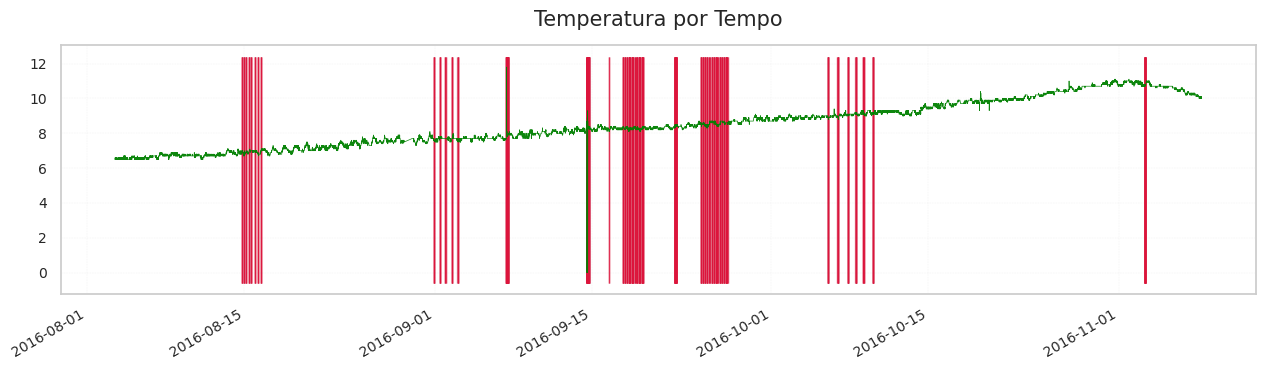

In [11]:
# Gráfico original: Temperatura por Tempo (overview)
fig, ax = plt.subplots(figsize=(13, 4)) 

ax.plot(
    df_ts.index,
    df_ts['Tp'],
    linestyle='-',
    color='green',
    linewidth=0.5, 
    alpha=0.95
)

ax.set_title('Temperatura por Tempo', fontsize=15, pad=14)
ax.grid(alpha=0.25, linestyle='--', linewidth=0.35)

event_times = df_ts.index[df_ts["EVENT"]]

if len(event_times) > 0:
    ymin, ymax = ax.get_ylim()
    ax.vlines(
        event_times,
        ymin=ymin, ymax=ymax,
        color="crimson",
        alpha=0.18,
        linewidth=0.95,
        zorder=1
    )

ax.tick_params(axis='both', which='major', labelsize=10)
fig.autofmt_xdate(rotation=30)

plt.tight_layout(pad=1.5)
plt.show()


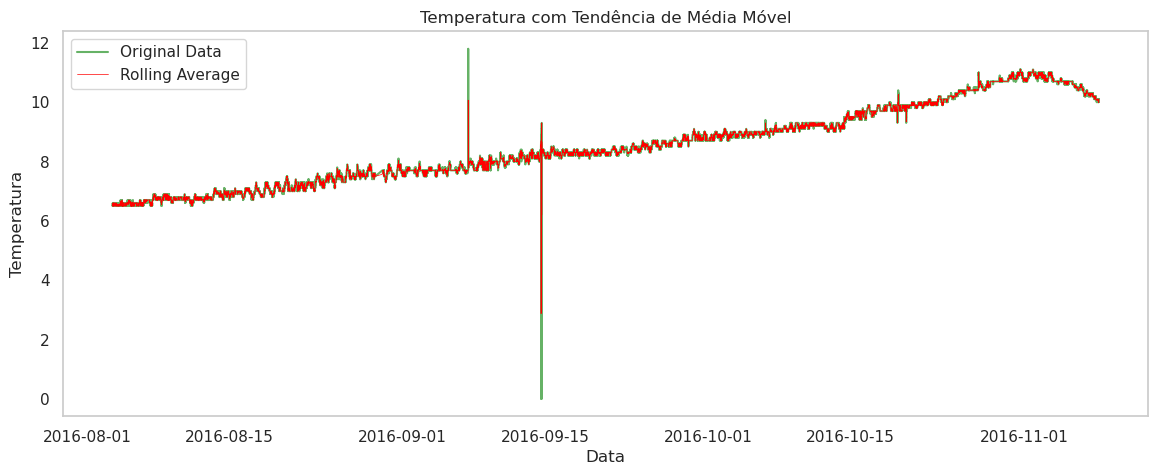

In [64]:
df_ts['Rolling_Avg'] = df_ts['Tp'].rolling(window=3).mean()

plt.plot(df_ts.index, df_ts['Tp'], color='green', label='Original Data', alpha=0.6)
plt.plot(df_ts.index, df_ts['Rolling_Avg'], color='red', label='Rolling Average', linewidth=0.5)
plt.title('Temperatura com Tendência de Média Móvel')
plt.xlabel('Data')
plt.ylabel('Temperatura')
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_14959/2929424483.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Month', y='Tp', data=df_ts, palette="coolwarm")


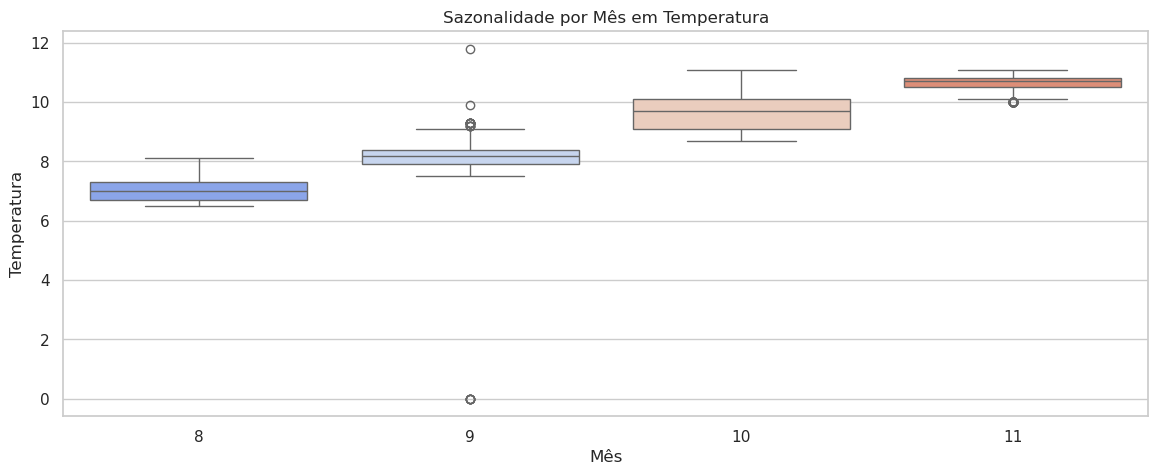

In [ ]:
if hasattr(df_ts.index, 'inferred_type') and df_ts.index.inferred_type == 'datetime64':
    df_ts['Month'] = df_ts.index.month
elif 'Time' in df_ts.columns:
    df_ts['Month'] = pd.to_datetime(df_ts['Time']).dt.month
else:
    raise ValueError("No datetime index or 'Time' column found for extracting month.")

sns.boxplot(x='Month', y='Tp', data=df_ts, palette="coolwarm")
plt.title('Sazonalidade por Mês em Temperatura')
plt.xlabel('Mês')
plt.ylabel('Temperatura')
plt.show()

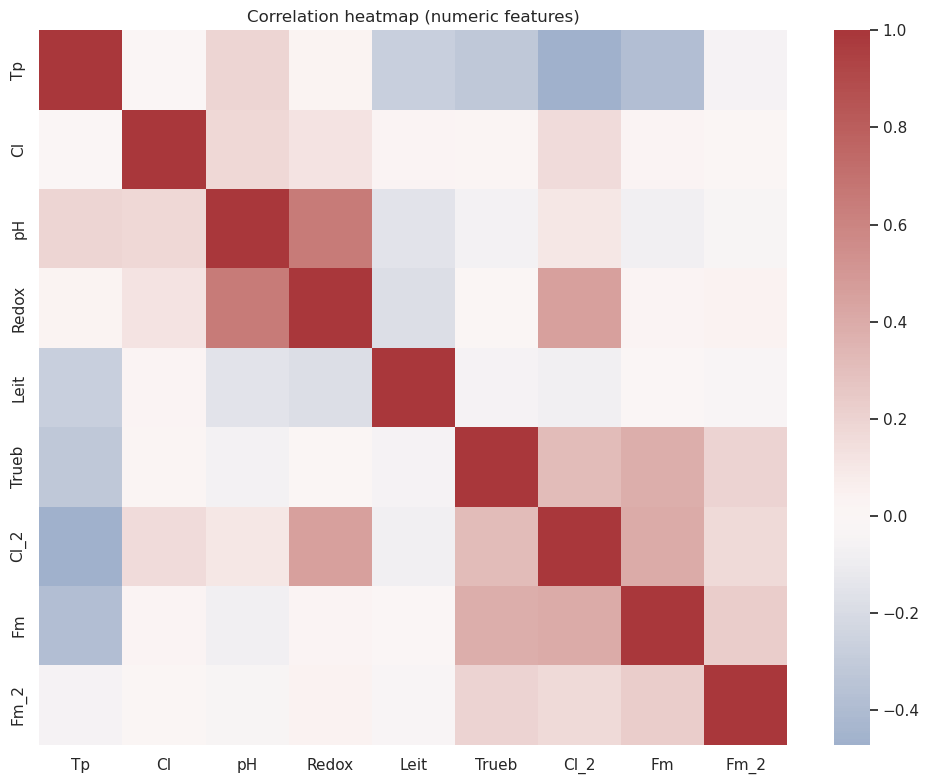

In [ ]:
numeric_cols = df_ts.select_dtypes(include=[np.number]).columns.tolist()
corr = df_ts[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="vlag", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
plt.show()

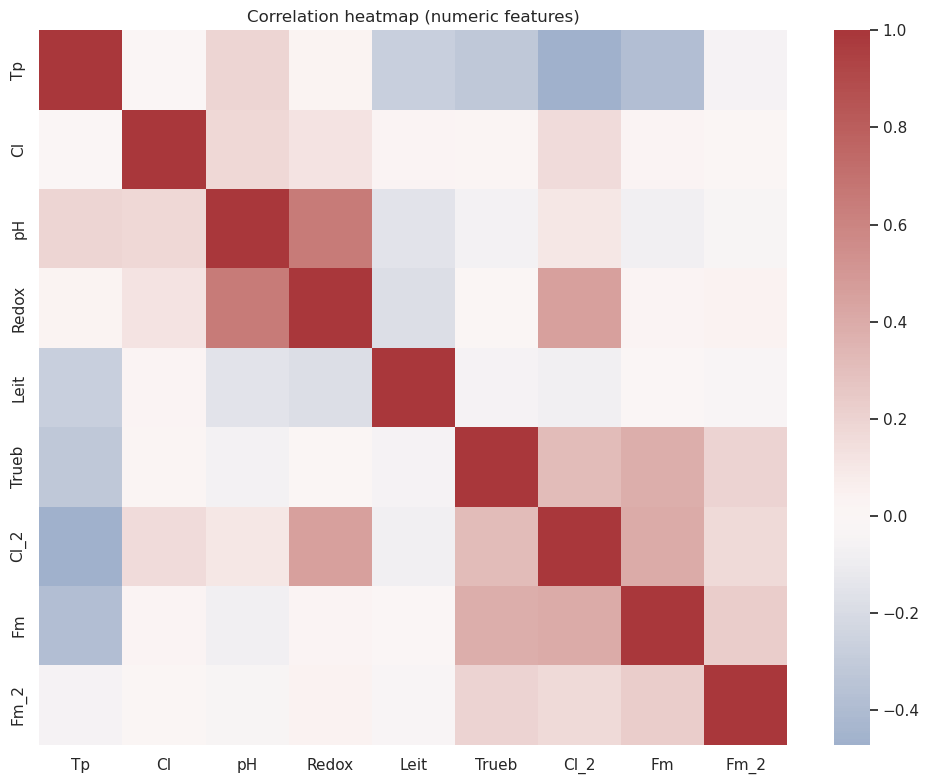

Saved: /home/nelso/Documents/IA - Detecção Falhas/reports/figures/correlation_heatmap.png


In [11]:
# Save correlation heatmap to figures
from pathlib import Path as _Path
numeric_cols = df_ts.select_dtypes(include=[np.number]).columns.tolist()
corr = df_ts[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap="vlag", center=0)
plt.title("Correlation heatmap (numeric features)")
plt.tight_layout()
out = _Path(FIGURES_DIR) / "correlation_heatmap.png"
plt.savefig(out, dpi=150, bbox_inches="tight")
plt.show()
print("Saved:", out)

## Resumo do Notebook

### Dados
- `df_ts`: DataFrame limpo, indexado por tempo, com 138.521 registros
- Período: 2016-08-03 a 2016-11-08
- 9 sensores: Tp, Cl, pH, Redox, Leit, Trueb, Cl_2, Fm, Fm_2
- 51 regiões de anomalia detectadas (coluna EVENT)

### Visualizações Criadas

1. **Séries Temporais**:
   - Visualização completa com marcação de eventos
   - Tendências com média móvel
   - Análise de sazonalidade (por mês)

2. **Análises Estatísticas**:
   - Distribuições de todas as variáveis
   - Matriz de correlação entre sensores
   - Reamostragem temporal (média por hora)

### Figuras Salvas
- Matriz de correlação: `reports/figures/correlation_heatmap.png`
- Outras figuras podem ser salvas conforme necessário

### Próximos Passos
Para análises focadas em anomalias (janelas de zoom, estatísticas de duração, etc.), consulte:
- **Notebook 03**: `03_anomaly_visualizations_gecco2018.ipynb`